In [1]:
import asyncio
import pymongo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

MONGO_HOST = "localhost"
MONGO_PORT = 27017

COLORS  = {'arbitrum':'LightBlue', 'optimism':'red', 'ethereum':'purple', 'zksync':'black', 'flashbots':'orange'}
ROLLUPS = ['ethereum', 'arbitrum', 'optimism', 'zksync']
LABELS  = ['Ethereum', 'Arbitrum', 'Optimism', 'zkSync']

mongo_connection = pymongo.MongoClient("mongodb://"+MONGO_HOST+":"+str(MONGO_PORT), maxPoolSize=None)

In [2]:
liq_arb_coll = mongo_connection['arbitrum']['mev_liquidation_results']
liq_opt_coll = mongo_connection['optimism']['mev_liquidation_results']
liq_eth_coll = mongo_connection['ethereum']['mev_liquidation_results']
liq_zk_coll = mongo_connection['zksync']['mev_liquidation_results']

arb_arb_coll = mongo_connection['arbitrum']['mev_arbitrage_results']
arb_opt_coll = mongo_connection['optimism']['mev_arbitrage_results']
arb_eth_coll = mongo_connection['ethereum']['mev_arbitrage_results']
arb_zk_coll = mongo_connection['zksync']['mev_arbitrage_results']

def get_liq_collections():
    return zip(ROLLUPS, LABELS, [liq_arb_coll, liq_opt_coll, liq_eth_coll, liq_zk_coll])

def get_arb_collections():
    return zip(ROLLUPS, LABELS, [arb_arb_coll, arb_opt_coll, arb_eth_coll, arb_zk_coll])

def coll_to_df(rollup, coll):
    print(f"Converting {rollup} collection {coll} to data frame...")
    return pd.DataFrame(list(coll.find({}, {"datetime":1, "total_cost_usd":1, "_id":0})))

In [3]:
async def add_iso_timestamps(platform, coll_name):
    pipeline = [
        {
            "$set": {
                "datetime": {"$toDate": {
                    "$multiply": [1000, {"$toLong": "$block_timestamp"}]
                }}
            },
        },
        {
            "$out" : { 
                "db": platform, "coll": coll_name 
            } 
        }
    ]
    # Run the aggregation pipeline
    mongo_connection[rollup][coll_name].aggregate(pipeline)

for rollup in ROLLUPS:
    print(f"Retimestamping {rollup} liquidations and arbitrages")
    task1 = asyncio.create_task(add_iso_timestamps(rollup, "mev_liquidation_results"))        
    task2 = asyncio.create_task(add_iso_timestamps(rollup, "mev_arbitrage_results"))
    
    await task1
    await task2

Retimestamping ethereum liquidations and arbitrages
Retimestamping arbitrum liquidations and arbitrages
Retimestamping optimism liquidations and arbitrages
Retimestamping zksync liquidations and arbitrages


In [4]:
liq_arb_df, liq_opt_df, liq_eth_df, liq_zk_df = tuple(coll_to_df(rollup, coll) for rollup, label, coll in get_liq_collections())
arb_arb_df, arb_opt_df, arb_eth_df, arb_zk_df = tuple(coll_to_df(rollup, coll) for rollup, label, coll in get_arb_collections())

def get_liq_dfs_pairs():
    return zip(ROLLUPS, LABELS, [liq_eth_df, liq_arb_df, liq_opt_df, liq_zk_df])

def get_arb_dfs_pairs():
    return zip(ROLLUPS, LABELS, [arb_eth_df, arb_arb_df, arb_opt_df, arb_zk_df])

Converting ethereum collection Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True, maxpoolsize=None), 'arbitrum'), 'mev_liquidation_results') to data frame...
Converting arbitrum collection Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True, maxpoolsize=None), 'optimism'), 'mev_liquidation_results') to data frame...
Converting optimism collection Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True, maxpoolsize=None), 'ethereum'), 'mev_liquidation_results') to data frame...
Converting zksync collection Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True, maxpoolsize=None), 'zksync'), 'mev_liquidation_results') to data frame...
Converting ethereum collection Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True, 

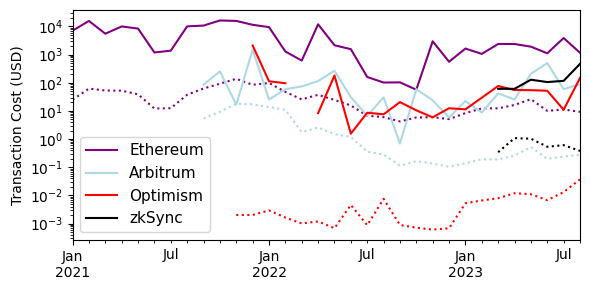

In [5]:
def plot_monthly_cost(data, is_arb):
    name, label, df = data
    df['datetime'] = pd.to_datetime(df['datetime'])  # Ensure the column is in datetime format
    df.set_index('datetime', inplace=True)  # Set the datetime column as the index

    monthly_df = df.resample('ME')['total_cost_usd'].median()
    if is_arb:
        monthly_df.plot(kind='line', label=label+"X", c=COLORS[name], linestyle='dotted')
    else:
        monthly_df.plot(kind='line', label=label, c=COLORS[name])

    # Reset the index to use 'datetime' as a column again
    df.reset_index(inplace=True)

plt.figure(figsize=(6, 3))

# draw a line plot of the monthly total_profit_eth over time for each rollup
for arb, liq in zip(get_arb_dfs_pairs(), get_liq_dfs_pairs()):
    plot_monthly_cost(liq, False)
    plot_monthly_cost(arb, True)

plt.ylabel('Transaction Cost (USD)')
handles = [plt.gca().lines[i] for i in [0, 2, 4, 6]]
plt.legend(handles=handles, labels=LABELS, prop={'size': 11})

plt.gca().set_xlabel('')  # Remove x-axis label
plt.yscale('log')

plt.tight_layout()
plt.savefig('figure_6.png', bbox_inches='tight', facecolor='white', transparent=True, dpi=1000)